This notebook will give you a demonstration on implementing a visual tranformer (ViT) using PyTorch from basic for emotion recognition from images.

The Vision Transformer, or ViT, is a SOTA model for image classification that employs a Transformer-like architecture over patches of the image. To read more about it, check: https://paperswithcode.com/method/vision-transformer

We will cover building a dataset from raw images and labels. Then, transform the dataset using image augmentation techniques and will implement attention tranformer architecture *linformer*. Finally, we will use *ViT* model to train our data and see results on test data.

Note that this is not a pretrained transformer model, hence we won't expect good accuracy.

### Load basic libraries

In [62]:
from __future__ import print_function

import itertools
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

### Dataset creation

We will start by taking the ZIP file which contains all images seperated by labels.Then, unziping the file into a folder *labelled_folder*

In [63]:
inputData = '/home/kc/j1guestgs01/DL_project/labelled.zip'

In [65]:
from zipfile import ZipFile
# Create a ZipFile Object and load sample.zip in it
with ZipFile(inputData, 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [66]:
for i in range(1,8):
  path, dirs, files = next(os.walk("/home/kc/j1guestgs01/DL_project/labelled_folder/" + str(i)))
  #print(len(files))
  file_count = len(files)
  print('No. of images are: ' + str(file_count) + ' in label ' + str(i))

No. of images are: 1619 in label 1
No. of images are: 355 in label 2
No. of images are: 877 in label 3
No. of images are: 5957 in label 4
No. of images are: 2460 in label 5
No. of images are: 867 in label 6
No. of images are: 3204 in label 7


In [67]:
os.makedirs('labelled_folder', exist_ok=True)

In [68]:
train_list = []
for i in range(1,8):
  train_path = 'labelled_folder/' + str(i) + '/'
  pre_list = glob.glob(os.path.join(train_path,'*.jpg'))
  for k in pre_list:
    train_list.append(k)
  #print(len(pre_list))
print('length of train_list is: ' + str(len(train_list)))

length of train_list is: 15339


**Defining labels**

Notes:
  + 1: Surprise
  + 2: Fear
  + 3: Disgust
  + 4: Happiness
  + 5: Sadness
  + 6: Anger
  + 7: Neutral

In [69]:
#manually defining the labels
p = [1,2,3,4,5,6,7]
q = [1619,355,877,5957,2460,867,3204]
lst = []
for i in p:
  for k in q:
    if p.index(i) == q.index(k):
      lst.append([i] * k)
labels = list(itertools.chain(*lst))

Finally, *train_list* contains a list of all images and *labels* is list on respective labels with length of 15359

#### Training settings

In [70]:
#Most of these values will be used later while training
batch_size = 64
epochs = 30
lr = 3e-5
gamma = 0.7
seed = 42

In [71]:
#seed_everything function will set a seed for methods wherever a constant result has to replicated
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [72]:
device = 'cuda'

### Data exploration: Plots

Lets explore the data by ploting some random images with there respective labels.

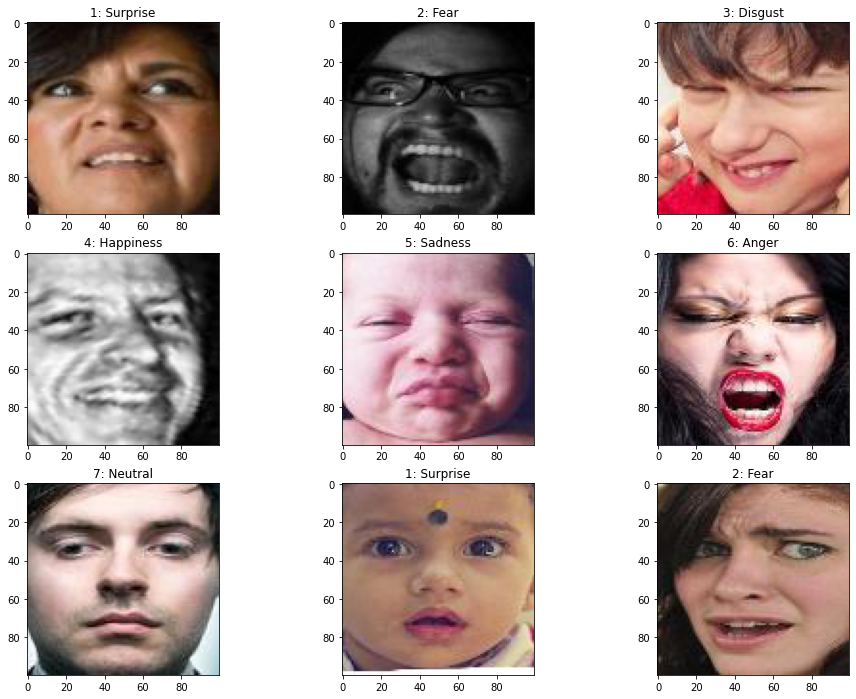

In [73]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
#print(len(axes.ravel()))
for idx, ax in enumerate(axes.ravel()):
    if idx == 0:
      img = Image.open(train_list[10])
      ax.set_title('1: Surprise')
      ax.imshow(img)
    if idx == 1:
      img = Image.open(train_list[1700])
      ax.set_title('2: Fear')
      ax.imshow(img)
    if idx == 2:
      img = Image.open(train_list[2000])
      ax.set_title('3: Disgust')
      ax.imshow(img)
    if idx == 3:
      img = Image.open(train_list[2900])
      ax.set_title('4: Happiness')
      ax.imshow(img)
    if idx == 4:
      img = Image.open(train_list[8900])
      ax.set_title('5: Sadness')
      ax.imshow(img)
    if idx == 5:
      img = Image.open(train_list[11300])
      ax.set_title('6: Anger')
      ax.imshow(img)
    if idx == 6:
      img = Image.open(train_list[12200])
      ax.set_title('7: Neutral')
      ax.imshow(img)
    if idx == 7:
      img = Image.open(train_list[11])
      ax.set_title('1: Surprise')
      ax.imshow(img)
    if idx == 8:
      img = Image.open(train_list[1701])
      ax.set_title('2: Fear')
      ax.imshow(img)

From the images we can see different facial expression for different emotions.

### Data Split

We will use **train_test_split** from **sklearn** library to split data. For now the function only split data into train and test, therefore, we will split it twice.

The ratio we have used is: train:valid:test = 80:10:10

In [74]:
train_list, val_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)
valid_list, test_list = train_test_split(val_list, 
                                          test_size=0.5,
                                          random_state=seed)

In [75]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 12271
Validation Data: 1534
Test Data: 1534


**Image Augumentation**

If you train your model on a large number of images then chances are high that the model will do classification with very good accuracy. But usually, there are cases when we do not have much data for model training. What should we do in that case? The problem can be solved by doing Data augmentation.
Techniques like padding, cropping, rotating, and flipping are the most common methods that are used over the images to increase the data size.To read more about it check, https://analyticsindiamag.com/image-data-augmentation-impacts-performance-of-image-classification-with-codes/#:~:text=Techniques%20like%20padding%2C%20cropping%2C%20rotating,the%20size%20of%20the%20data.

In [76]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)), #resizing
        transforms.RandomResizedCrop(224), #croping the image
        transforms.RandomHorizontalFlip(), #fliping the image on horizontal axis
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

### Load Dataset

The first step is to load and prepare your data. PyTorch provides the Dataset class that you can extend and customize to load your dataset.
For example, the constructor of your dataset object can load your data file (e.g. a CSV file). You can then override the __len__() function that can be used to get the length of the dataset (number of rows or samples), and the __getitem__() function that is used to get a specific sample by index.

When loading your dataset, you can also perform any required transforms, such as scaling or encoding.

Lets build the constructor class now.

In [77]:
class RAFBDDataset(Dataset):
    """RAF-BD Emotion dataset."""
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        #print(img_path)
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = int(img_path.split("/")[-2].split(".")[0])
        #print(label)
        if label == 1:
          label = 0
        elif label == 2:
          label = 1
        elif label == 3:
          label = 2
        elif label == 4:
          label = 3
        elif label == 5:
          label = 4
        elif label == 6:
          label = 5
        else: 
          label = 6

        return img_transformed, label

Now, its time to use the dataset constructor class to create numerical data for each dataset

In [78]:
train_data = RAFBDDataset(train_list, transform=train_transforms)
valid_data = RAFBDDataset(valid_list, transform=val_transforms)
test_data = RAFBDDataset(test_list, transform=test_transforms)

In [79]:
type(train_data)

__main__.RAFBDDataset

Once loaded, PyTorch provides the **DataLoader** class to navigate a Dataset instance during the training and evaluation of your model.

A **DataLoader** instance can be created for the training dataset, test dataset, and even a validation dataset.

In [80]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

## Efficient Attention

Facebook released a Transformer architecture called **Linformer** to detect hate-speech using there NLP model. Linformer is implemented in the git-repo: https://github.com/lucidrains/linformer. We will be use this transformer to apply attention in the ViT model

### Linformer

In [85]:
! pip -q install vit_pytorch linformer

In [86]:
from linformer import Linformer

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64           #this is the k that the key/values are projected to along the sequence dimension
)

### Visual Transformer

The next step is to define a model. The idiom for defining a model in PyTorch involves defining a class that extends the Module class. But we will be use ViT class of transformer to train our model instead of building from scratch. You can read more about it at https://github.com/lucidrains/vit-pytorch

In [87]:
! pip install vit-pytorch

In [88]:
from vit_pytorch.efficient import ViT

model = ViT(
    dim=128, # Last dimension of output tensor after linear transformation
    image_size=224, #Image size. If you have rectangular images, make sure your image size is the maximum of the width and height
    patch_size=32, #Number of patches. image_size must be divisible by patch_size.
    num_classes=7, #Number of classes to classify.
    transformer=efficient_transformer,
    channels=3, #Number of image's channels
).to(device)

### Training

Let's define the optimiser,loss criteria and scheduler. Follow the official PyTorch page : https://pytorch.org/docs/stable/optim.html to learn more about the input required

In [89]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr) #Adam solver is used
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma) #step_size is Period of learning rate decay, gamma (float) – Multiplicative factor of learning rate decay

Now, lets train over model and check the accuracy and losses we will get on validata data.

In [57]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        CUDA_LAUNCH_BLOCKING=1
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.6584 - acc: 0.3869 - val_loss : 1.6311 - val_acc: 0.3900



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.6341 - acc: 0.3890 - val_loss : 1.6138 - val_acc: 0.3925



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.6184 - acc: 0.3918 - val_loss : 1.6064 - val_acc: 0.3925



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 4 - loss : 1.6047 - acc: 0.3936 - val_loss : 1.5973 - val_acc: 0.3873



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 5 - loss : 1.5944 - acc: 0.3979 - val_loss : 1.5835 - val_acc: 0.3958



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 6 - loss : 1.5898 - acc: 0.4005 - val_loss : 1.5817 - val_acc: 0.4036



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 7 - loss : 1.5830 - acc: 0.4023 - val_loss : 1.5663 - val_acc: 0.4074



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 8 - loss : 1.5696 - acc: 0.4058 - val_loss : 1.5581 - val_acc: 0.4178



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.5597 - acc: 0.4148 - val_loss : 1.5658 - val_acc: 0.4139



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.5537 - acc: 0.4140 - val_loss : 1.5473 - val_acc: 0.4107



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.5430 - acc: 0.4167 - val_loss : 1.5409 - val_acc: 0.4133



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.5441 - acc: 0.4146 - val_loss : 1.5473 - val_acc: 0.4198



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.5377 - acc: 0.4194 - val_loss : 1.5399 - val_acc: 0.4095



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.5339 - acc: 0.4172 - val_loss : 1.5192 - val_acc: 0.4283



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.5312 - acc: 0.4240 - val_loss : 1.5341 - val_acc: 0.4407



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.5281 - acc: 0.4200 - val_loss : 1.5312 - val_acc: 0.4277



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 17 - loss : 1.5225 - acc: 0.4286 - val_loss : 1.5387 - val_acc: 0.4257



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 18 - loss : 1.5175 - acc: 0.4292 - val_loss : 1.5322 - val_acc: 0.4346



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 19 - loss : 1.5130 - acc: 0.4263 - val_loss : 1.5437 - val_acc: 0.4333



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 20 - loss : 1.5120 - acc: 0.4272 - val_loss : 1.5171 - val_acc: 0.4334



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 21 - loss : 1.5033 - acc: 0.4340 - val_loss : 1.5140 - val_acc: 0.4367



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 22 - loss : 1.5030 - acc: 0.4347 - val_loss : 1.5108 - val_acc: 0.4315



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 23 - loss : 1.4951 - acc: 0.4379 - val_loss : 1.4910 - val_acc: 0.4328



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 24 - loss : 1.4957 - acc: 0.4362 - val_loss : 1.5074 - val_acc: 0.4381



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 25 - loss : 1.4894 - acc: 0.4361 - val_loss : 1.4988 - val_acc: 0.4380



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 26 - loss : 1.4852 - acc: 0.4408 - val_loss : 1.5151 - val_acc: 0.4394



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 27 - loss : 1.4895 - acc: 0.4383 - val_loss : 1.4834 - val_acc: 0.4401



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 28 - loss : 1.4759 - acc: 0.4468 - val_loss : 1.4747 - val_acc: 0.4530



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 29 - loss : 1.4752 - acc: 0.4432 - val_loss : 1.4711 - val_acc: 0.4563



  0%|          | 0/192 [00:00<?, ?it/s]

Epoch : 30 - loss : 1.4732 - acc: 0.4483 - val_loss : 1.4749 - val_acc: 0.4473



After training for 30 epochs, the best training accuracy is 44.32% and validation accuracy is 45.63%

### Test

In [60]:
with torch.no_grad():
    test_accuracy = 0
    test_loss = 0
    for data, label in test_loader:
        data = data.to(device)
        label = label.to(device)

        test_output = model(data)
        test_loss = criterion(test_output, label)

        acc = (test_output.argmax(dim=1) == label).float().mean()
        test_accuracy = acc / len(test_loader)
        test_loss = val_loss / len(test_loader)

    print(
        f"test_loss : {test_loss:.4f} - test_acc: {test_accuracy:.4f}"
    )

test_loss : 1.4658 - test_acc: 0.4512


The best test accuracy we got is 45.12%